# Multi-Layer Perceptron from the scratch

Nowadays, multi-Layer neural network has been proved to be a powerful tool in many data science problems. Though many existing packages have provided the interfaces to call this function (e.g. scikit-learn), it would be good to write some toy model by your own. Through this practice, you will gain some experience in software engineering. More importantly, you will understand the underlying mathmatics better and know how to fix the troubles when you run the code from the existing softwares. In the tutorial, we will continue to use the wine data and figure out how to write our own MLP classfier.

Let us start with the example in the previous lecture
```
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
```
<img src="img/MLP.jpeg" style="width: 800px;"/>
<center> Figure 1, the MLP model used in this lecture</center>

You should be able to understand most of the parameters at the moment. To realize a minimum version of MLP, we can try to implement the following parameters into our model:
- hidden_layer_sizes: to make life easier, let us just consider 2 hidden layer models
- max_iter: maximum number of iteractions
- learning_rate_init: 

Note that we will completely ignore the terms related to regularization

## Forward propagation
$
\begin{align}
h_1 &= w_1\cdot x + b_1\\
F_1 & = f(h_1)\\
h_2 &= w_2\cdot f_1(w_1\cdot x + b_1)) + b_2 = w_2\cdot F_1 + b_2\\
F_2 & = f(h_2)\\
h_3 &= w_3\cdot f_2((w_2\cdot f_1(w_1\cdot x + b_1)) + b_2)) + b_3 = w_3\cdot F_2 + b_3\\
y` &= f_3(h_3) \\
\end{align}
$

## Loss function
$
\begin{align}
L = \frac{1}{2}(y`-y)^2
\end{align}
$

## Back propagation

$
\begin{align}
\frac{\partial L}{\partial y} & = y-Y \\
\frac{\partial L}{\partial h3} &= \frac{\partial L}{\partial y} (1-h_3)h_3 \\
\frac{\partial L}{\partial w_3}& = \frac{\partial L}{\partial h_3}F_2,~~~
\frac{\partial L}{\partial b_3} = \frac{\partial L}{\partial h_3}, ~~~ 
\frac{\partial L}{\partial F_2} = \frac{\partial L}{\partial h_3}w_3 \\  
\frac{\partial L}{\partial h_2} & = \frac{\partial L}{\partial F_2}(1-h_2)h_2\\
\frac{\partial L}{\partial w_2} & = \frac{\partial L}{\partial h_2}\frac{\partial h_2}{\partial w_2}               
                                  = \frac{\partial L}{\partial h_2} F_1,~~~
\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial f_2}\frac{\partial f_2}{\partial b_2}
                                  = \frac{\partial L}{\partial f_2},~~~
\frac{\partial L}{\partial F_1} = \frac{\partial L}{\partial h_2}w_2\\
\frac{\partial L}{\partial h_1} & = \frac{\partial L}{\partial F_1}(1-h_1)h_1 \\  
\frac{\partial L}{\partial w_2} & = \frac{\partial L}{\partial h_1}\frac{\partial h_1}{\partial w_1}               
                                  = \frac{\partial L}{\partial h_1} \cdot x,~~~
\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial h_1}\frac{\partial h_1}{\partial b_1}
                                  = \frac{\partial L}{\partial h_1}\\
\end{align}
$



In [61]:
%matplotlib inline

import numpy as np
import sys
import matplotlib.pyplot as plt

class my_MLPClassifier(object):
    """
    Basic MultiLayer Perceptron (MLP) neural network.
    Args:
    hidden layer: []
    max_iterations: []
    """
    def __init__(self, hidden, max_iter=10, 
                 learning_rate=1e-3, decay_rate=0.99, 
                 activation='sigmoid', loss='mse'):
        """
        :param hidden: number of hidden neurons
        :param iterations: how many epochs
        :param learning_rate: initial learning rate
        """
        # initialize input parameters
        self.iterations = max_iter
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.n_hid1, self.n_hid2 = hidden[0], hidden[1]
        self.activation_method = activation
        self.loss_method= loss
        
    def fit(self, input, target):      
        """
        input: 2D array, N_sample * N_attributes
        output: 1D array, N_sample * 1
        """
        # Initialize the weights and bias according to the input/target data
        dim_in, dim_out = input.shape[1], 1
        self.w1 = np.random.randn(dim_in, self.n_hid1) # [13,4] -- 52 weights 
        self.w2 = np.random.randn(self.n_hid1, self.n_hid2) # [4,4] -- 16 weights
        self.w3 = np.random.randn(self.n_hid2, dim_out) # [4,1] -- 4 weights
        self.b1 = np.random.randn(1,self.n_hid1) # [1,4] -- 4 biases
        self.b2 = np.random.randn(1,self.n_hid2) # [1,4] -- 4 biases
        self.b3 = np.random.randn(1,dim_out)  # [1,1] -- 1 bias
        loss_hist = [] # track loss for printing
        
        """
        training
        """
        
        for i in range(self.iterations):
            # forward: input --> hidden layer 1 -- hidden layer 2 -- output
            (h1, h2, y) = self.forward(input)
            
            # evaluate and print the loss function
            loss = self.loss(y, target)
            loss_hist.append(loss)
            
            # backprop: output --> hidden layer 2 --> hidden layer 1 --> input
            """
            deltas are the derivatives of the inputs and outputs of the nodes which are used to find the gradients
            of the parameters with respect to the cost: gradw & gradb.
            
            after finding gradw and gradb, the weights and biases are updated.
            """
            
            delta3 = self.grad_loss(y, target) * self.grad_activation(y) 
            gradw3 = np.dot(delta3, h2)
            gradw3 = np.reshape(gradw3, [len(gradw3), 1])
            gradb3 = np.sum(delta3)
            delta2 = (np.transpose(np.dot(self.w3,np.transpose(np.vstack(delta3)))) * 
                      self.grad_activation(h2))
            gradw2 = np.dot(np.transpose(delta2),h1)
            gradb2 = np.sum(delta2)
            
            delta = (np.transpose(np.dot(self.w2,np.transpose(np.vstack(delta2)))) * 
                     self.grad_activation(h1))
            gradw = np.transpose(np.dot(np.transpose(delta),input))
            gradb = np.sum(delta)
            
            # updating the weight
            #w3, b3, w2, b2, w1, b1 = self.w3.flatten(), self.b3, self.w2, self.b2, self.w1, self.b1
            learning_rate = self.learning_rate * (self.decay_rate**i)
            self.w3 -= learning_rate*gradw3
            self.b3 -= learning_rate*gradb3
            self.w2 -= learning_rate*gradw2
            self.b2 -= learning_rate*gradb2
            self.w1 -= learning_rate*gradw
            self.b1 -= learning_rate*gradb
        self.weights = (self.w3, self.w2, self.w1)
        self.bias = (self.b3, self.b2, self.b1)
        print('loss is {:4f} after {:4d} iterations'.format(loss, self.iterations))
        plt.title('training curve')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(np.arange(0,self.iterations),loss_hist)
  
    def loss(self, y, target):
        if self.loss_method=='mse':
            return 0.5*np.sum(np.power(y-target,2))/y.shape[0]
        elif self.loss.method=='log_loss':
            pass
        else:
            raise Notimplementederror
    
    def grad_loss(self, y, target):
        if self.loss_method=='mse':
            return y-target
        elif self.loss_method=='log_loss':
            pass
        else:
            raise NotImplementedError

    def activation(self, x):
        return 1./(1+np.exp(-x))
    
    def grad_activation(self, x):
        if self.activation_method=='sigmoid':
            return self.activation(x)*(1-self.activation(x))
        elif self.activation_method=='log_loss':
            pass
        else:
            raise NotImplementedError
            
    def forward(self, X):
        h1 = self.activation(np.dot(X,self.w1)+self.b1)
        h2 = self.activation(np.dot(h1,self.w2)+self.b2)
        y = self.activation(np.dot(h2,self.w3)+self.b3)
        return (h1, h2, y.flatten())
        
    def predict(self, X):
        """
        return predictions after training algorithm
        """
        (h1, h2, y) = self.forward(X)
        return y

In [62]:
#Obtain and preprocess the data
from sklearn.datasets import load_wine
data=load_wine()
x, Y = data.data, data.target

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
scaler.fit(x)  
x0 = scaler.transform(x) 

loss is 0.339369 after   10 iterations


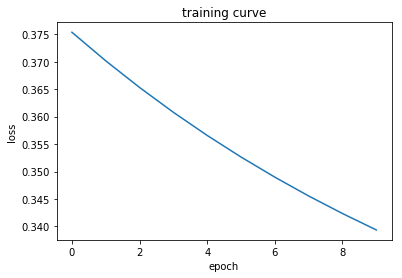

In [63]:
### mlp parameters
my_mlp = my_MLPClassifier(hidden=[4,4],max_iter=10)
my_mlp.fit(x0, Y)

In [73]:
a=my_mlp.predict(x0)
y=[round(s) for s in 3*a]
#y=[int(s) for s in 3*a]
np.array(y).reshape(1,len(y))

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2.]])

In [74]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])